Mean customers in system    => 0.9877181881972052
Confidence Interval         => [0.9058258323536744, 1.069610544040736]

Mean wait time in system    => 0.9992860883929803
Confidence Interval         => [0.9318621065426542, 1.0667100702433063]

Mean 0 state time in system => 0.5064960980944043
Confidence Interval         => [0.49227421623948725, 0.5207179799493213]

Fraction of times 0 state   => 0.25393769146960676
Confidence Interval         => [0.24473888006818553, 0.26313650287102797]

{0: 0.5133931685423977, 1: 0.7639614914908983, 2: 0.8768127641904745, 3: 0.9319438675802054, 4: 0.9557258662902047, 5: 0.9735077286947145, 6: 0.9835457590694935, 7: 0.9896890765467747, 8: 0.9938211201496404, 9: 0.9950245080821672, 10: 0.9959163193377387, 11: 0.9963598018410793, 12: 0.9991076644097124, 13: 1.0}


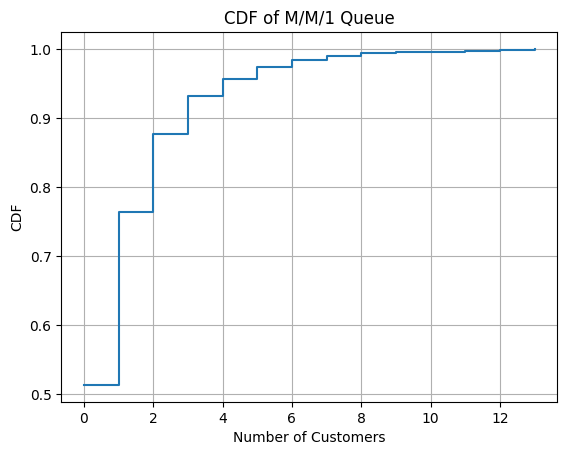

In [2]:
from collections import defaultdict
from helpers import *

# function to properly simulate the queue
def simulate(_lambda, _mu, total_time = 10, total_rounds = 1, track_states=False):
  state_time_distribution = defaultdict(float) if track_states else None
  mean_customers_per_round = [] # mean number of customers in the system per round
  mean_wait_time_per_round = [] # mean wait time in the system per round
  mean_empty_state_time_per_round = [] # mean time in which the system was empty per round
  fraction_times_hit_empty_per_round = [] # fraction of times the system hit 0 customers per round

  # main loop
  for _ in range(total_rounds):
    simulation_queue = Queue() # event queue
    simulation_time = 0 # current time in the simulation
    persons_counter = 0 # number of persons currently in the system
    persons_arrived = 0 # number of persons that arrived in the system
    times_system_empty = 0 # number of times the system hit 0 persons
    events_counter = 0 # number of events treated

    arrival_time = arrival_dist(_lambda) # time of the next arrival
    service_end_time = total_time # time of the next departure
    last_event_time = 0 # time of the last event treated
    area_person_time = 0 # area of the number of persons in the system over time, used to calculate some metrics
    empty_state_time = 0 # amount of time in which the system was empty

    simulation_queue.push((TYPES[0], arrival_time))

    while True:
      event = simulation_queue.pop() # takes the next event from the queue

      # run simulation until an event time exceeds the timeframe
      if event[1] > total_time:
        if persons_counter == 0:
          empty_state_time += total_time - last_event_time
        break
      
      if track_states:
        time_spent_in_state = event[1] - last_event_time
        state_time_distribution[persons_counter] += time_spent_in_state

      if event[0] == TYPES[0]:          # if the event is an arrival
        simulation_time = event[1]
        area_person_time += persons_counter * (simulation_time - last_event_time)
        persons_counter += 1
        persons_arrived += 1
        arrival_time = simulation_time + arrival_dist(_lambda)
        simulation_queue.push((TYPES[0], arrival_time))

        if persons_counter == 1:  # if changed from state 0 to 1, push departure and update empty time
          empty_state_time += simulation_time - last_event_time
          service_end_time = simulation_time + departure_dist(_mu)
          simulation_queue.push((TYPES[1], service_end_time))

      elif event[0] == TYPES[1]:       # if the event is a departure
        simulation_time = event[1]
        area_person_time += persons_counter * (simulation_time - last_event_time)
        persons_counter -= 1

        if persons_counter > 0: # if there are still people in the system, push next departure
          service_end_time = simulation_time + departure_dist(_mu)
          simulation_queue.push((TYPES[1], service_end_time))
        else:                  # if the system became empty, update the number of times it became empty
          times_system_empty += 1

      last_event_time = simulation_time # after treating the event, update last event time
      events_counter += 1 # update the number of events treated

    # store the results of the round into lists
    mean_customers_per_round.append(area_person_time/total_time)
    mean_wait_time_per_round.append(area_person_time/persons_arrived)
    mean_empty_state_time_per_round.append(empty_state_time/total_time)
    fraction_times_hit_empty_per_round.append(times_system_empty/events_counter)

  if track_states:
    return state_time_distribution
  else:
    return Statistics(mean_customers_per_round, mean_wait_time_per_round,
                    mean_empty_state_time_per_round, fraction_times_hit_empty_per_round)


_lambda = 1

_mu = 2

total_time = 1000

total_rounds = 10



# Run the simulation

stats = simulate(_lambda, _mu, total_time, total_rounds)

state_time_distribution = simulate(_lambda, _mu, total_time, track_states=True)



# Normalize the state times

total_time_recorded = sum(state_time_distribution.values())

state_probabilities = {k: v / total_time_recorded for k, v in state_time_distribution.items()}



# Calculate the CDF

cdf = {}

cumulative_probability = 0

for state in sorted(state_probabilities.keys()):

  cumulative_probability += state_probabilities[state]

  cdf[state] = cumulative_probability

print(stats)
print(cdf)

import matplotlib.pyplot as plt



# CDF values from the simulation

cdf_values = list(cdf.values())

cdf_states = list(cdf.keys())



# Plot the CDF
plt.step(cdf_states, cdf_values, where='post')
plt.xlabel('Number of Customers')

plt.ylabel('CDF')

plt.title('CDF of M/M/1 Queue')

plt.grid(True)

plt.show()

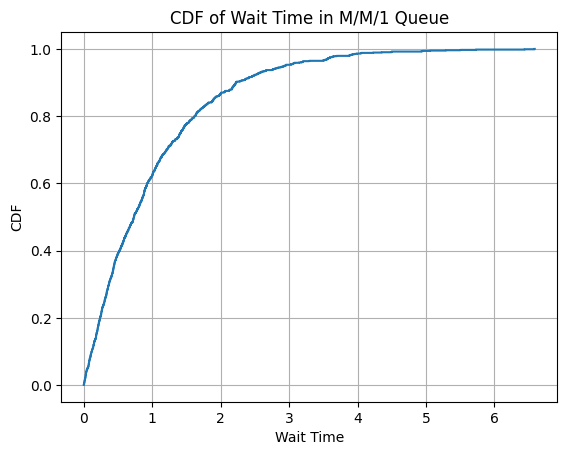

In [3]:
from bisect import bisect_right

def simulate_with_wait_time_cdf(_lambda, _mu, total_time=10, total_rounds=1, track_wait_times=False):
    wait_times = [] if track_wait_times else None
    
    for _ in range(total_rounds):
        simulation_queue = Queue()
        wait_time_queue = []  # To store wait times for each customer

        simulation_time = 0
        persons_counter = 0

        arrival_time = arrival_dist(_lambda)
        service_end_time = total_time

        simulation_queue.push(("Arrival", arrival_time))

        while True:
            event = simulation_queue.pop()

            if event[1] > total_time:
                break

            if event[0] == "Arrival":
                simulation_time = event[1]
                persons_counter += 1
                arrival_time = simulation_time + arrival_dist(_lambda)
                simulation_queue.push(("Arrival", arrival_time))

                if persons_counter == 1:
                    service_end_time = simulation_time + departure_dist(_mu)
                    simulation_queue.push(("Departure", service_end_time))
                wait_time_queue.append([simulation_time, 0])  # Arrival time, Wait time placeholder

            elif event[0] == "Departure":
                simulation_time = event[1]
                persons_counter -= 1

                # Calculate wait time for the departed customer
                arrival_time_of_departed_customer, _ = wait_time_queue.pop(0)
                wait_time = simulation_time - arrival_time_of_departed_customer
                if track_wait_times:
                    wait_times.append(wait_time)

                if persons_counter > 0:
                    service_end_time = simulation_time + departure_dist(_mu)
                    simulation_queue.push(("Departure", service_end_time))

    if track_wait_times:
        # Sort wait times to calculate CDF
        sorted_wait_times = sorted(wait_times)
        n = len(sorted_wait_times)
        cdf_wait_times = {x: (bisect_right(sorted_wait_times, x) / n) for x in sorted_wait_times}
        return cdf_wait_times
    else:
        return None

# Run the simulation to collect wait times and calculate their CDF
wait_time_cdf = simulate_with_wait_time_cdf(_lambda, _mu, total_time, total_rounds=1, track_wait_times=True)

# Plotting the CDF for wait times
plt.figure()
plt.step(list(wait_time_cdf.keys()), list(wait_time_cdf.values()), where='post')
plt.xlabel('Wait Time')
plt.ylabel('CDF')
plt.title('CDF of Wait Time in M/M/1 Queue')
plt.grid(True)
plt.show()
